## Finding an euclidean embedding of Warren's wormhole maze

### 1. Introduction

In *Wormholes in virtual space: From cognitive maps to cognitive graphs* (Warren et al., 2017), participants explored a virtual maze with two wormholes that instantly teleported the participants from one position to another (unnoticed).
After learning the maze, the participants had to estimate shortcuts between different locations, and the estimated angle was measured.

<img src="figures/labeledMaze.png" width="240"/>


Estimates close to the wormhole entrances were heavily biased towards the shifted object location rather than the *euclidean ground truth* position:

<img src="figures/bookcaseCactus.png" width="420"/>


This is agreeable with the **labeled graph model** which assumes that the internal representation of the maze exists as a graph with local measurements of distances and angles, but not as an euclidean embedding. Any shortcut estimates are a result of vector addition along the shortest path in the graph, leading to distortions close to the wormholes because the shortest paths lead through them.

Importantly, the authors agree that a distorted euclidean map may exists that would lead to similar estimates, but reject that hypothesis because the distorted map *"must still satisfy the metric postulates"* (Warren et al., 2017) - and the distorted map apparently violates positivity.

#### Here, I show that

1. such distorted maps exist by finding embeddings of the labeled graph by minimizing the local distance and angle errors.
2. the distorted maps explain the measurements just as well as the vector addition hypothesis, even without any fitting to subject data.

I also argue that the distorted embedding does not violate any metric postulates from the point of view of the subjects (because it is a valid embedding in Euclidean space!).

### 2. Graph setup

To find a metric embedding of the labeled graph, a model of the graph needs to be defined. This is already non-trivial, because the graph could consist of any number of edges, nodes and measurements along the maze.
Given that the maze basically only consists of straight segments and corners, I opted for a graph that consists of one node per corner or landmark:

<img src="figures/warrenGtPositions.png" width="420"/>

The pixel positions of nodes in the image are the euclidean **ground truth**, which I will later use for analysis.

Note that these choices heavily affects the embeddings! The graph shown next is only one possibility out of an infinite number of possible graphs.

In [1]:
# Graph creation based on pixel position

import numpy as np
import networkx as nx 

# Pixel positions in "warren ground truth positions.png"
image_points = np.array([
    [133,909],[57,909],[61,779],[377,777],[403,669],
    [517,667],[553,511],[559,309],[663,245],[663,59],
    [785,59],[787,119],[53,59],[305,319],[185,313],
    [403,961],[183,1143],[100,1081],[481,1137],[579,1117],
    [705,521],[911,341],[1049,345],[1025,543],[1041,751],
    [919,931],[709,919],[653,723],[733,625],[879,637],
    [871,755],[1017,213],[1019,63],[897,61],[897,99],
    [1165,61],[1165,1165],[1005,1167],[861,1065],[847,1165],
    [781,1163],[595,607]
    ])

n = image_points.shape[0]

gt = image_points.astype(float)

offset = gt[0]
refLength = np.linalg.norm(gt[1]-gt[0])
gt = (gt-offset)/refLength*[1,-1] # Image coordinate to euclidean xy correction

# for exact measurements of wormhole1's entrance
wh1_entrances = np.array([[61,559],[557,57]],float)
wh1_entrances = (wh1_entrances-offset)/refLength*[1,-1] 

# 2 versions: Gn - no wormhole | Gw - wormhole
Gn = nx.Graph()
Gw = nx.Graph()
Gn.add_nodes_from(range(n))
Gw.add_nodes_from(range(n))

Gn.add_edges_from([
    (0,1),(1,2),(2,3),(3,4),(3,15),(4,5),(4,13),(5,41),(6,7),(6,41),
    (7,8),(8,9),(9,10),(10,11),(13,14),(15,16),(15,18),(16,17),(18,19),
    (20,21),(20,41),(21,22),(21,31),(22,23),(23,24),(24,25),(25,26),(25,38),
    (26,27),(27,41),(28,29),(28,41),(29,30),(31,32),(32,33),(33,34),(37,38),(38,39),
    (39,40),
    (2,12),(9,12),(32,35),(35,36),(36,37)    # WH-related edges
    ])

Gw.add_edges_from([
    (0,1),(1,2),(2,3),(3,4),(3,15),(4,5),(4,13),(5,41),(6,7),(6,41),
    (7,8),(8,9),(9,10),(10,11),(13,14),(15,16),(15,18),(16,17),(18,19),
    (20,21),(20,41),(21,22),(21,31),(22,23),(23,24),(24,25),(25,26),(25,38),
    (26,27),(27,41),(28,29),(28,41),(29,30),(31,32),(32,33),(33,34),(37,38),(38,39),
    (39,40),
    (2,9),(32,36),(36,37)  # WH-related edges
    ])


# exact distances
D = np.zeros((n,n))
for u,v in Gn.edges:
    D[u,v]=np.linalg.norm(gt[u]-gt[v])
    D[v,u]=np.linalg.norm(gt[u]-gt[v])
D[2,9] = D[9,2] = np.linalg.norm(gt[2]-wh1_entrances[0])\
    +np.linalg.norm(gt[9]-wh1_entrances[1])
D[32,36] = D[36,32] = D[32,35]

#triplets, exact angles
Tn = []
Tw = []
A = np.zeros((n, n, n),float)
for i in range(n):
    for j in range(n):
        for k in range(n):
            if Gn.has_edge(i,j) and Gn.has_edge(j,k):
                Tn.append([i,j,k])
                A[i,j,k] = np.math.atan2(np.linalg.det([gt[j]-gt[i], gt[j]-gt[k]]),
                    np.dot(gt[j]-gt[i], gt[j]-gt[k]))
            if Gw.has_edge(i,j) and Gw.has_edge(j,k):
                Tw.append([i,j,k])
Tn = np.asarray(Tn)
Tw = np.asarray(Tw)

# Wormhole angle changes
A[1,2,9] = A[1,2,12]
A[9,2,1] = A[12,2,1]
A[3,2,9] = A[3,2,12]
A[9,2,3] = A[12,2,3]
A[2,9,8] = A[12,9,8]
A[8,9,2] = A[8,9,12]
A[2,9,10] = A[12,9,10]
A[10,9,2] = A[10,9,12]

A[31,32,36] = A[31,32,35]
A[36,32,31] = A[35,32,31]
A[32,36,37] = A[35,36,37]
A[37,36,32] = A[37,36,35]
A[33,32,36] = A[33,32,35]
A[36,32,33] = A[35,32,33]

Gw.remove_node(12)
Gw.remove_node(35)

# Object positions
O = {
    "bookcase":0,
    "cactus":11,
    "clock":14,
    "earth":17,
    "flamingo":19,
    "gear":23,
    "moon":30,
    "well":34,
    "sink":40
}

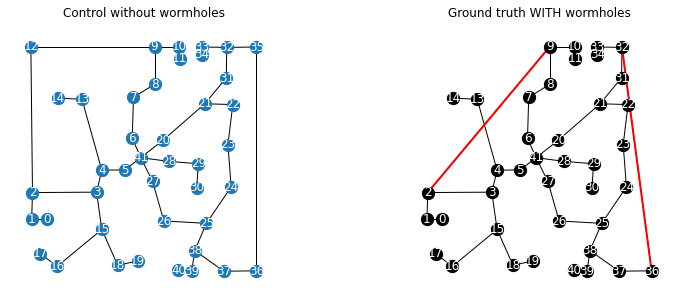

In [3]:
# [RUN TWICE for large plots!] The graphs with ther nodes at the respective pixel
# positions (gt)

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [13, 5]

ax = plt.subplot(121, aspect='equal')
nx.draw(Gn, with_labels=True, node_size=150, pos=gt, font_color='w')
ax.set_title("Control without wormholes")

ax = plt.subplot(122, aspect='equal')
plt.plot([gt[2][0], gt[9][0]], [gt[2][1], gt[9][1]], color='r', linewidth=2)
plt.plot([gt[32][0], gt[36][0]], [gt[32][1],
         gt[36][1]], color='r', linewidth=2)
nx.draw(Gw, with_labels=True, node_size=150,
        pos=gt, node_color='k', font_color='w')
ax.set_title("Ground truth WITH wormholes")

plt.show()


These graphs can now be used to visualize the estimates of participants that were measured by Warren et al. (2017). The following example shows the shortcut estimates of subject 1 (dotted lines) compared to the predictions that follow from the euclidean ground truth model or the shortest path vector addition (solid lines):

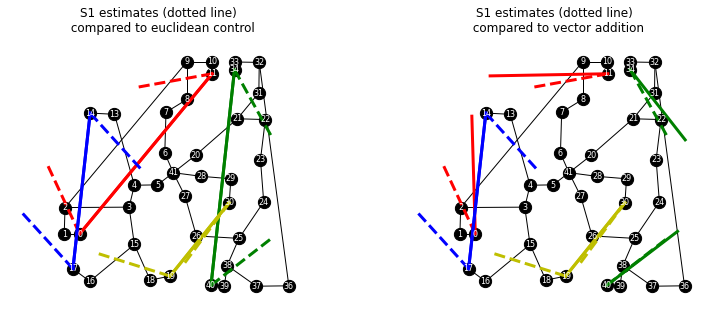

In [4]:
# Example: load data of Subject 1
import function_repository4 as fr4

def dataPerSubject(data, s):
    """Importer function to extract a line from Warren's data"""

    dataPS = [
        [O["cactus"], O["bookcase"], data[s, 0]],
        [O["bookcase"], O["cactus"], data[s, 1]],
        [O["well"], O["sink"], data[s, 2]],
        [O["sink"], O["well"], data[s, 3]],
        [O["clock"], O["earth"], data[s, 4]],
        [O["earth"], O["clock"], data[s, 5]],
        [O["moon"], O["flamingo"], data[s, 6]],
        [O["flamingo"], O["moon"], data[s, 7]]
    ]

    for d in dataPS:
        # transform angular differences into global angles
        d[2] = np.deg2rad(d[2])+fr4.angle(gt[d[0]], gt[d[1]])

    return dataPS


data = np.loadtxt("datasets/data_wh1.txt",
                  delimiter='\t', skiprows=1, dtype=float)
# correction for mirrored angles due to the way the data is set-up
data[:, 0] *= -1
data[:, 3:] *= -1

subject = 1
data_sub = dataPerSubject(data, subject)

estimate_colors = ['r', 'r', 'g', 'g', 'b', 'b', 'y', 'y']

ax = plt.subplot(121, aspect='equal')
nx.draw(Gw, with_labels=True, node_size=150, pos=gt,
        node_color='k', font_size=8, font_color='w')
ax.set_title(
    "S{} estimates (dotted line) \n compared to euclidean control".format(subject))
for d, c in zip(data_sub, estimate_colors):
    fr4.plotLineAndMeasurement(d, gt, c, 3)


ax = plt.subplot(122, aspect='equal')
nx.draw(Gw, with_labels=True, node_size=150, pos=gt,
        node_color='k', font_size=8, font_color='w')
ax.set_title(
    "S{} estimates (dotted line) \n compared to vector addition".format(subject))
for d, c in zip(data_sub, estimate_colors):
    v = fr4.vectorAlongPath(nx.dijkstra_path(Gw, d[0], d[1]), gt,  D, A)
    fr4.plotVectorAndMeasurement(v, d, gt, c, 3)


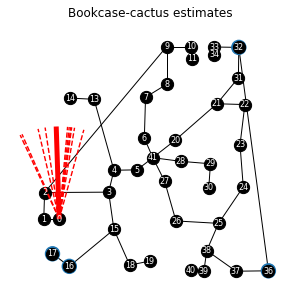

In [5]:
# Additional plot of all measurements for a specific object pair
import scipy.stats

ax = plt.subplot(111, aspect='equal')

nx.draw(Gw, with_labels=True, node_size=150, pos=gt,
        node_color='k', font_size=8, font_color='w')
ax.set_title("Bookcase-cactus estimates")

ax.add_patch(plt.Circle(gt[16], 0.5))
ax.add_patch(plt.Circle(gt[17], 0.5))
ax.add_patch(plt.Circle(gt[32], 0.5))
ax.add_patch(plt.Circle(gt[36], 0.5))

plt.axis('off')

avg = []
for s in range(data.shape[0]):
        m = dataPerSubject(data, s)[1]
        avg.append(m[2])
        plt.plot([gt[m[0]][0], gt[m[0]][0]+6*np.cos(m[2])],
                [gt[m[0]][1], gt[m[0]][1]+6*np.sin(m[2])],
                color='r', linestyle='--', linewidth=1.4, solid_capstyle='butt')
        
average = scipy.stats.circmean(avg, np.pi, -np.pi)
plt.plot([gt[m[0]][0], gt[m[0]][0]+6*np.cos(average)],
                [gt[m[0]][1], gt[m[0]][1]+6*np.sin(average)],
                color='r', linewidth=5, solid_capstyle='butt')

# plt.savefig("plots/shortcuts_bk-cact.png", dpi=300, bbox_inches='tight')

plt.show()

The idea is now to find embeddings that minimize the error to the local measurements in the graph (that are here assumed to be perfect). The predictions that the embeddings make about shortcuts can then be compared to other models.

For minimization, a stress function is defined after Hübner & Mallot, 2007 or eq. 8.11 in *An Introduction to Spatial Cognition* (Mallot, 2024):

In [6]:
# define embedding stress function
from numba import jit

@jit
def fast_stress(X, l1, l2, distances, angles, triplets):
    """Graph stress function, optimized by jit"""

    x = np.reshape(X, (int(X.shape[0]/2), 2))
    stress = 0
    for t in triplets:
        i, j, k = t
        stress += l1*(np.dot(x[j]-x[i], x[j]-x[k]) - distances[i, j] *
                      distances[j, k]*np.cos(angles[i, j, k]))**2
        stress += l2*(fr4.jit_cross3(x[j]-x[i], x[j]-x[k]) - distances[i, j] *
                      distances[j, k]*np.sin(angles[i, j, k]))**2
    return stress


Embedding 1 - Iterations: 219, stress: 450.67999157828
Embedding 2 - Iterations: 201, stress: 367.3553405821104


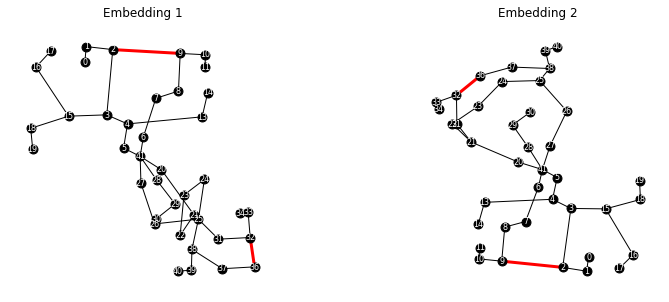

In [7]:
# Find lowest stress embedding based on random starting seeds
# via numerical approximation (quasi-newton methods)

# There seem to exists two local minima (in 1000 random restarts)
# E.g., seed 3873 and 3875


import scipy.optimize

# Node 0 is constrained to (0,0)
cons = ({'type': 'eq', 'fun': lambda x: x[0]},
        {'type': 'eq', 'fun': lambda x: x[1]})

np.random.seed(3873)
x0 = np.random.uniform(size=(2, n),low=0.0,high=20.0)
sl1 = scipy.optimize.minimize(fast_stress, x0.flatten(), (1, 1, D, A, Tw),
                              method='SLSQP', constraints=cons, options={'maxiter': 500})
print("Embedding 1 - Iterations: {}, stress: {}".format(sl1.nit, sl1.fun))
em1 = sl1.x.reshape(n, 2)

np.random.seed(3875)
x0 = np.random.uniform(size=(2, n),low=0.0,high=20.0)
sl2 = scipy.optimize.minimize(fast_stress, x0.flatten(), (1, 1, D, A, Tw),
                              method='SLSQP', constraints=cons, options={'maxiter': 500})
print("Embedding 2 - Iterations: {}, stress: {}".format(sl2.nit, sl2.fun))
em2 = sl2.x.reshape(n, 2)

ax = plt.subplot(121, aspect='equal')
plt.plot([em1[2][0], em1[9][0]], [em1[2][1],
         em1[9][1]], color='r', linewidth=3)
plt.plot([em1[32][0], em1[36][0]], [em1[32][1],
         em1[36][1]], color='r', linewidth=3)
nx.draw(Gw, with_labels=True, node_size=80, pos=em1, node_color='k', font_size=8,
        font_color='w')
ax.set_title("Embedding 1")

ax = plt.subplot(122, aspect='equal')
plt.plot([em2[2][0], em2[9][0]], [em2[2][1],
         em2[9][1]], color='r', linewidth=3)
plt.plot([em2[32][0], em2[36][0]], [em2[32][1],
         em2[36][1]], color='r', linewidth=3)
nx.draw(Gw, with_labels=True, node_size=80, pos=em2, node_color='k', font_size=8,
        font_color='w')
ax.set_title("Embedding 2")
plt.show()


Note that these embeddings only minimize the difference between the graph and the ground truth on which the local angles are based on. The distortions are a result of the wormhole but no subject data is included.

Embedding 2 has a lower overall stress than embedding 1, but, as it turns out, embedding 1 fits the data better (shown later).

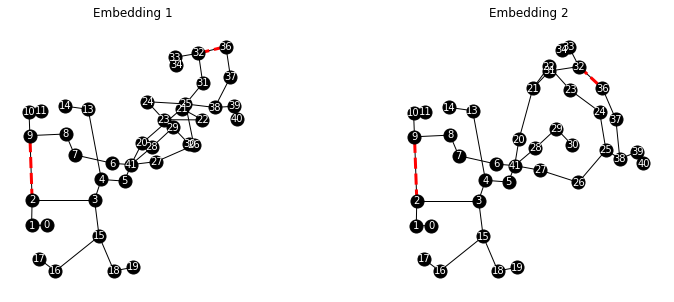

In [8]:
# Rotate embeddings so that edge e(2,3) faces to the east/in x-direction
r1 = fr4.angle(em1[2], em1[3])
em1 = em1@np.array([[np.cos(r1), -np.sin(r1)], [np.sin(r1), np.cos(r1)]])

r2 = fr4.angle(em2[2], em2[3])
em2 = em2@np.array([[np.cos(r2), -np.sin(r2)], [np.sin(r2), np.cos(r2)]])

# ax = plt.subplot(131, aspect='equal')
# nx.draw(Gn, with_labels=True, node_size=80, pos=gt, font_size=8, font_color='w')
# ax.set_title("Euclidean control")

ax = plt.subplot(121, aspect='equal')
plt.plot([em1[2][0], em1[9][0]], [em1[2][1],
         em1[9][1]], color='r', linestyle='--', linewidth=3, solid_capstyle='butt')
plt.plot([em1[32][0], em1[36][0]], [em1[32][1],
         em1[36][1]], color='r', linestyle='--', linewidth=3, solid_capstyle='butt')
nx.draw(Gw, with_labels=True, node_size=170, pos=em1, node_color='k', font_size=10,
        font_color='w')
ax.set_title("Embedding 1")

ax = plt.subplot(122, aspect='equal')
plt.plot([em2[2][0], em2[9][0]], [em2[2][1],
         em2[9][1]], color='r', linestyle='--', linewidth=3, solid_capstyle='butt')
plt.plot([em2[32][0], em2[36][0]], [em2[32][1],
         em2[36][1]], color='r', linestyle='--', linewidth=3, solid_capstyle='butt')
nx.draw(Gw, with_labels=True, node_size=170, pos=em2, node_color='k', font_size=10,
        font_color='w')
ax.set_title("Embedding 2")

# plt.savefig("plots/embeddings.png", dpi=300, bbox_inches='tight')

plt.show()


Comparing the estimates to predicitons by the embeddings is not as simple as in the Euclidean control because the reference direction ("north") is unknown or may be not the same in all parts of the graph.

Instead, the angles are transformed into local measurements by using the difference between the estimate and the neighboring node in the ground truth as a reference. This is actually quite straight-forward in this case because all landmark (where estimates are given) locations have only one neighbor.

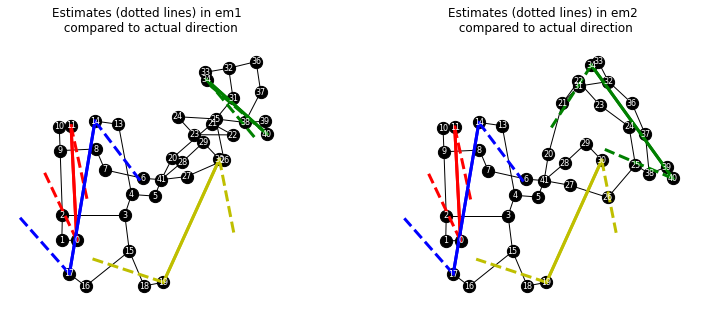

In [9]:
# transform estimates to local embedding coordinates and plot the results

est_local1 = fr4.makeLocal(Gw, gt, em1, data_sub)
est_local2 = fr4.makeLocal(Gw, gt, em2, data_sub)


ax = plt.subplot(121, aspect='equal')
nx.draw(Gw, with_labels=True, node_size=150, pos=em1, node_color='k', font_size=8,
        font_color='w')
ax.set_title("Estimates (dotted lines) in em1 \n compared to actual direction")
for d, c in zip(est_local1, estimate_colors):
    fr4.plotLineAndMeasurement(d, em1, c, 3)

ax = plt.subplot(122, aspect='equal')
ax.set_title("Estimates (dotted lines) in em2 \n compared to actual direction")
nx.draw(Gw, with_labels=True, node_size=150, pos=em2, node_color='k', font_size=8,
        font_color='w')
for d, c in zip(est_local2, estimate_colors):
    fr4.plotLineAndMeasurement(d, em2, c, 3)


Side-by-side comparison of vector addition and the estimates in embedding 1:

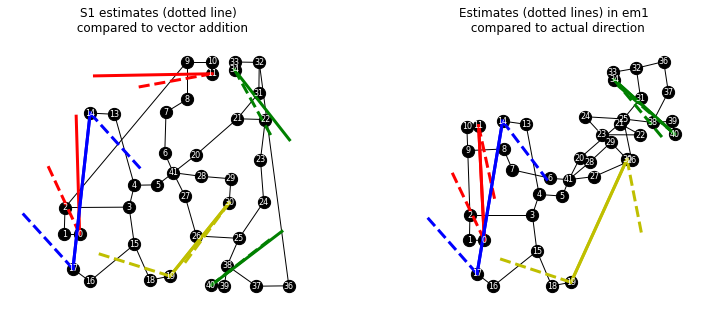

In [10]:
# plot vector addition on ground truth and estimates in embedding 1

ax = plt.subplot(121, aspect='equal')
nx.draw(Gw, with_labels=True, node_size=150, pos=gt,
        node_color='k', font_size=8, font_color='w')
ax.set_title("S{} estimates (dotted line) \n compared to vector addition".format(subject))
for d, c in zip(data_sub, estimate_colors):
    v = fr4.vectorAlongPath(nx.dijkstra_path(Gw, d[0], d[1]), gt,  D, A)
    fr4.plotVectorAndMeasurement(v, d, gt, c, 3)

ax = plt.subplot(122, aspect='equal')
nx.draw(Gw, with_labels=True, node_size=150, pos=em1, node_color='k', font_size=8,
        font_color='w')
ax.set_title("Estimates (dotted lines) in em1 \n compared to actual direction")
for d, c in zip(est_local1, estimate_colors):
    fr4.plotLineAndMeasurement(d, em1, c, 3)

The prediction of  embedding 1 looks reasonably similar to the prediction by the vector addition model. The yellow estimate seems quite a bit worse in the embedding but it is bad to begin with.

To quantify the prediction errors, two (similar) functions are defined:

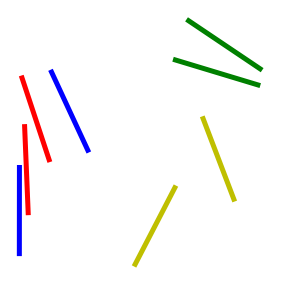

In [13]:
# === Additional plots of the average directional estimate


import scipy.stats


data_avg = np.rad2deg(np.expand_dims(scipy.stats.circmean(
    np.deg2rad(data), np.pi, -np.pi, axis=0), 0))
data_sub = dataPerSubject(data_avg, 0)
est_local1 = fr4.makeLocal(Gw, gt, em1, data_sub)

# ax = plt.subplot(121, aspect='equal')
# plt.axis('off')
# for d, c in zip(data_sub, estimate_colors):
#     v = fr4.vectorAlongPath(nx.dijkstra_path(Gw, d[0], d[1]), gt,  D, A)
#     # fr4.plotVectorAndMeasurement(v, d, gt, c, 1)
#     plt.plot([gt[d[0]][0], gt[d[0]][0]+5*np.cos(d[2])],
#              [gt[d[0]][1], gt[d[0]][1]+5*np.sin(d[2])],
#              color=c, linewidth=5, solid_capstyle='butt')

ax = plt.subplot(121, aspect='equal')
plt.axis('off')
# nx.draw(Gw, with_labels=True, node_size=150, pos=em1, node_color='k', font_size=8,
#         font_color='w')
for d, c in zip(est_local1, estimate_colors):
    plt.plot([em1[d[0]][0], em1[d[0]][0]+5*np.cos(d[2])],
             [em1[d[0]][1], em1[d[0]][1]+5*np.sin(d[2])],
             color=c, linewidth=5, solid_capstyle='butt')

# plt.savefig("plots/shortcuts_avg_embed.png", dpi=300,
#             bbox_inches='tight', transparent=True)




In [14]:
# Error function definition

import scipy.stats


def UVDistanceError(m, vec):
    """
    Squared distance between unit vectors of measurement m and vec
    Vec should be either the vector addition in ground truth coordinates or the direct
    connection in the embeddings
    """
    u = np.array([np.cos(m[2]), np.sin(m[2])])
    v = vec/np.linalg.norm(vec)
    return np.linalg.norm(u-v)**2


def angularError(m, vec, ed=1):
    """
    Probably the Error function used in Warren 2017.
    ed = 1/-1 is the direction in which the error increases, as in Warren2017
    """
    a = m[2]
    b = np.arctan2(vec[1], vec[0])
    smaller_angle = (a-b+np.pi) % (2*np.pi)-np.pi
    return ed*smaller_angle


# testing case for data from subject 0
leftRightIncrease = [-1, 1, 1, -1, -1, -1, -1, -1]

ue_vectorAddition = []
ae_vectorAddition = []
for ed, m in zip(leftRightIncrease, data_sub):
    v = fr4.vectorAlongPath(nx.dijkstra_path(Gw, m[0], m[1]), gt, D, A)
    ue_vectorAddition.append(UVDistanceError(m, v))
    ae_vectorAddition.append(angularError(m, v, ed))

ue_em1 = []
ae_em1 = []
for ed, m in zip(leftRightIncrease, est_local1):
    v = em1[m[1]]-em1[m[0]]
    ue_em1.append(UVDistanceError(m, v))
    ae_em1.append(angularError(m, v, ed))

ue_em2 = []
ae_em2 = []
for ed, m in zip(leftRightIncrease, est_local2):
    v = em2[m[1]]-em2[m[0]]
    ue_em2.append(UVDistanceError(m, v))
    ae_em2.append(angularError(m, v, ed))

print("Results:")

print("Avg. unit vector distance error: va: {:.4f} | em1: {:.4f} | em2: {:.4f}".format(
    np.mean(np.asarray(ue_vectorAddition)), np.mean(np.asarray(ue_em1)),
    np.mean(np.asarray(ue_em2))))

print("Avg. angular error: gt: {:.4f}° | em1: {:.4f}° | em2: {:.4f}°".format(
    np.rad2deg(scipy.stats.circmean(
        np.asarray(ae_vectorAddition), np.pi, -np.pi)),
    np.rad2deg(scipy.stats.circmean(np.asarray(ae_em1), np.pi, -np.pi)),
    np.rad2deg(scipy.stats.circmean(np.asarray(ae_em2), np.pi, -np.pi))))

print("Avg. absolute angular error: gt: {:.4f}° | em1: {:.4f}° | em2: {:.4f}°".format(
    np.rad2deg(scipy.stats.circmean(
        np.abs(np.asarray(ae_vectorAddition)), np.pi, -np.pi)),
    np.rad2deg(scipy.stats.circmean(
        np.abs(np.asarray(ae_em1)), np.pi, -np.pi)),
    np.rad2deg(scipy.stats.circmean(np.abs(np.asarray(ae_em2)), np.pi, -np.pi))))


Results:
Avg. unit vector distance error: va: 0.0944 | em1: 0.1568 | em2: 0.7111
Avg. angular error: gt: -12.4667° | em1: -14.8023° | em2: -39.8830°
Avg. absolute angular error: gt: 14.2815° | em1: 17.5458° | em2: 44.5526°


In [15]:
# Create a dataset over all subjects (n=10, 8 tests in 3 envs. each -> 10x24 table)

dataset_ue = []
dataset_ae = []

for s in range(len(data)):
    data_sub = dataPerSubject(data, s)
    est_local1 = fr4.makeLocal(Gw, gt, em1, data_sub)
    est_local2 = fr4.makeLocal(Gw, gt, em2, data_sub)

    ue_vectorAddition = []
    ae_vectorAddition = []
    for ed, m in zip(leftRightIncrease, data_sub):
        v = fr4.vectorAlongPath(nx.dijkstra_path(Gw, m[0], m[1]), gt, D, A)
        ue_vectorAddition.append(UVDistanceError(m, v))
        ae_vectorAddition.append(angularError(m, v, ed))

    ue_em1 = []
    ae_em1 = []
    for ed, m in zip(leftRightIncrease, est_local1):
        v = em1[m[1]]-em1[m[0]]
        ue_em1.append(UVDistanceError(m, v))
        ae_em1.append(angularError(m, v, ed))

    ue_em2 = []
    ae_em2 = []
    for ed, m in zip(leftRightIncrease, est_local2):
        v = em2[m[1]]-em2[m[0]]
        ue_em2.append(UVDistanceError(m, v))
        ae_em2.append(angularError(m, v, ed))

    dataset_ue.append(ue_vectorAddition+ue_em1+ue_em2)
    dataset_ae.append(ae_vectorAddition+ae_em1+ae_em2)

dataset_ue = np.asarray(dataset_ue)
dataset_ae = np.asarray(dataset_ae)
print("Dataset_ue shape: {}".format(dataset_ue.shape))
print("Dataset_ae shape: {}".format(dataset_ae.shape))

# [commented out to avoid acccidental overwriting] save the dataset
# np.savetxt("datasets/dataset_ue.txt", dataset_ue, delimiter="\t", fmt="%f")
# np.savetxt("datasets/dataset_ae.txt", dataset_ae, delimiter="\t", fmt="%f")


Dataset_ue shape: (10, 24)
Dataset_ae shape: (10, 24)
